In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Jupyter display
%matplotlib inline

# -------------------------------------------------------------------------
# Nicer plotting defaults
# -------------------------------------------------------------------------
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (5, 3)     # per-plot default size
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.4
plt.rcParams["lines.linewidth"] = 1.8
plt.rcParams["font.size"] = 11


# Base directory for CSV logs
BASE_DIR = Path("./results/var_models")


# -------------------------------------------------------------------------
# TensorBoard-style smoothing (exact match to TB smoothing slider)
# -------------------------------------------------------------------------
def tensorboard_smooth(values, weight: float):
    """
    Reproduce TensorBoard's smoothing exactly (EMA with debiasing).
    weight: 0..1 (same as TB smoothing slider)
    """
    values = np.asarray(values, dtype=float)
    last = 0.0
    num_acc = 0
    out = []

    for v in values:
        last = last * weight + (1.0 - weight) * v
        num_acc += 1

        # debias
        debias = 1.0 - weight ** num_acc
        out.append(last / debias)

    return np.array(out)


# -------------------------------------------------------------------------
# Load TensorBoard-exported CSV file
# -------------------------------------------------------------------------
def load_tensorboard_csv(path: Path,
                         step_col="Step",
                         value_col="Value",
                         tb_smooth_weight=0.95,
                         max_step=None,
                         stride=1):
    """
    Load TensorBoard CSV (columns: Wall time, Step, Value),
    apply TensorBoard-style smoothing, and optionally trim/stride.
    """
    df = pd.read_csv(path)

    # Sanity checks
    if step_col not in df.columns:
        raise ValueError(f"Column '{step_col}' not found in {path}")
    if value_col not in df.columns:
        raise ValueError(f"Column '{value_col}' not found in {path}")

    # Keep only necessary columns
    df = df[[step_col, value_col]].copy()
    df = df.sort_values(step_col).reset_index(drop=True)

    # Limit steps
    if max_step is not None:
        df = df[df[step_col] <= max_step]

    # Downsample if desired
    if stride > 1:
        df = df.iloc[::stride].reset_index(drop=True)

    # Apply TensorBoard smoothing
    df[value_col + "_smooth"] = tensorboard_smooth(df[value_col], tb_smooth_weight)

    return df

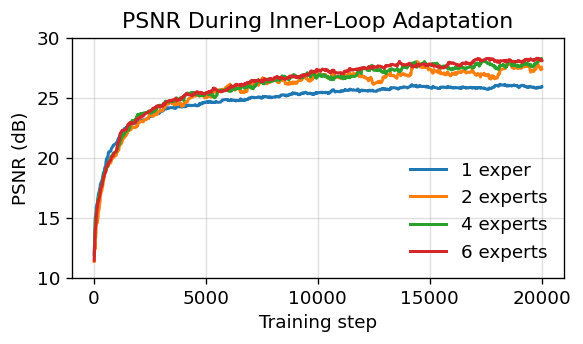

Saved: results/var_models/plots/psnrin_experts.pdf


In [ ]:
# =======================================================================================
# ============================== EXPERIMENT 1 PSNRIN STEPS ==============================
# =======================================================================================
file_1 = BASE_DIR / "1_mod_psnrin.csv"

file_2 = BASE_DIR / "2_mod_psnrin.csv"
file_4 = BASE_DIR / "4_mod_psnrin.csv"
file_6 = BASE_DIR / "6_mod_psnrin.csv"

df1 = load_tensorboard_csv(file_1, tb_smooth_weight=0.95, max_step=20000, stride=1)
df2 = load_tensorboard_csv(file_2, tb_smooth_weight=0.95, max_step=20000, stride=1)
df4 = load_tensorboard_csv(file_4, tb_smooth_weight=0.95, max_step=df2["Step"].max(), stride=1)
df6 = load_tensorboard_csv(file_6, tb_smooth_weight=0.95, max_step=20000, stride=1)

fig, ax = plt.subplots()
ax.set_ylim(10, 30)
ax.set_yticks([10, 15, 20, 25, 30])

ax.plot(df1["Step"], df1["Value_smooth"], label="1 exper")
ax.plot(df2["Step"], df2["Value_smooth"], label="2 experts")
ax.plot(df4["Step"], df4["Value_smooth"], label="4 experts")
ax.plot(df6["Step"], df6["Value_smooth"], label="6 experts")

ax.set_xlabel("Training step")
ax.set_ylabel("PSNR (dB)")
ax.set_title("PSNR During Inner-Loop Adaptation")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

out_dir = BASE_DIR / "plots"
out_dir.mkdir(parents=True, exist_ok=True)

out_path = out_dir / "psnrin_experts.pdf"
fig.savefig(out_path, bbox_inches="tight")
print("Saved:", out_path)

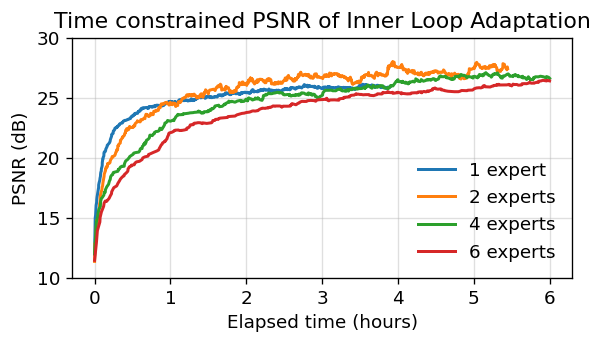

Saved: results/var_models/plots/psnrin_experts_time.pdf


In [15]:
# =======================================================================================
# ============================== EXPERIMENT 2 PSNRIN TIME ==============================
# =======================================================================================
MAX_DURATION_HOURS = 6
def add_elapsed_hours(csv_path, df_smooth):
    # raw CSV straight from TensorBoard export
    raw = pd.read_csv(csv_path)

    # be a bit robust in case the column is e.g. 'Wall time' or 'Wall Time'
    time_col = [c for c in raw.columns if "wall" in c.lower()][0]

    t0 = raw[time_col].iloc[0]
    raw["ElapsedHours"] = (raw[time_col] - t0) / 3600.0

    # keep only what we need for merge
    raw = raw[["Step", "ElapsedHours"]]

    # merge with smoothed df on Step
    df_merged = pd.merge(df_smooth, raw, on="Step", how="left")
    return df_merged

df1_t = add_elapsed_hours(file_1, df1)
df2_t = add_elapsed_hours(file_2, df2)
df4_t = add_elapsed_hours(file_4, df4)
df6_t = add_elapsed_hours(file_6, df6)


df1_t = add_elapsed_hours(file_1, df1)
df2_t = add_elapsed_hours(file_2, df2)
df4_t = add_elapsed_hours(file_4, df4)
df6_t = add_elapsed_hours(file_6, df6)


fig, ax = plt.subplots()
ax.set_ylim(10, 30)
ax.set_yticks([10, 15, 20, 25, 30])

for df_t, label in [
    (df1_t, "1 expert"),
    (df2_t, "2 experts"),
    (df4_t, "4 experts"),
    (df6_t, "6 experts"),
]:
    df_plot = df_t[df_t["ElapsedHours"] <= MAX_DURATION_HOURS]
    ax.plot(df_plot["ElapsedHours"], df_plot["Value_smooth"], label=label)

ax.set_xlabel("Elapsed time (hours)")
ax.set_ylabel("PSNR (dB)")
ax.set_title("Time constrained PSNR of Inner Loop Adaptation")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

out_path = out_dir / "psnrin_experts_time.pdf"
fig.savefig(out_path, bbox_inches="tight")
print("Saved:", out_path)


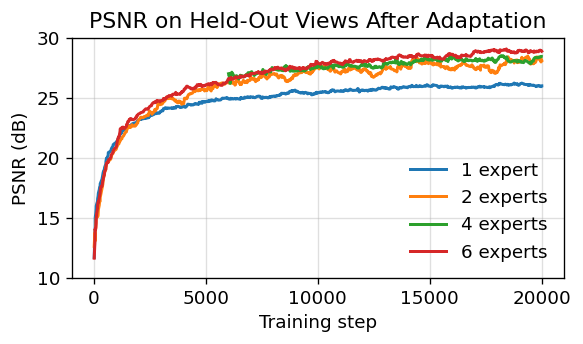

Saved: results/var_models/plots/psnrout_experts.pdf


In [4]:
# =========================================================================
# ============================== EXPERIMENT 2 ==============================
# =========================================================================
file_1_out = BASE_DIR / "1_mod_psnrout.csv"
file_2_out = BASE_DIR / "2_mod_psnrout.csv"
file_4_out = BASE_DIR / "4_mod_psnrout.csv"
file_6_out = BASE_DIR / "6_mod_psnrout.csv"

df1_out = load_tensorboard_csv(file_1_out, tb_smooth_weight=0.95, max_step=20000)
df2_out = load_tensorboard_csv(file_2_out, tb_smooth_weight=0.95, max_step=20000)
df4_out = load_tensorboard_csv(file_4_out, tb_smooth_weight=0.95, max_step=20000)
df6_out = load_tensorboard_csv(file_6_out, tb_smooth_weight=0.95, max_step=20000)

fig, ax = plt.subplots()
ax.set_ylim(10, 30)
ax.set_yticks([10, 15, 20, 25, 30])

ax.plot(df1_out["Step"], df1_out["Value_smooth"], label="1 expert")
ax.plot(df2_out["Step"], df2_out["Value_smooth"], label="2 experts")
ax.plot(df4_out["Step"], df4_out["Value_smooth"], label="4 experts")
ax.plot(df6_out["Step"], df6_out["Value_smooth"], label="6 experts")

ax.set_xlabel("Training step")
ax.set_ylabel("PSNR (dB)")
ax.set_title("PSNR on Held-Out Views After Adaptation")
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

out_path2 = out_dir / "psnrout_experts.pdf"
fig.savefig(out_path2, bbox_inches="tight")
print("Saved:", out_path2)
